<a href="https://colab.research.google.com/github/PanovEN/projects/blob/main/%D0%A2%D0%93%D0%A3__%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_EDA_%D0%B1%D0%B5%D0%B7_%D1%81%D0%B1%D0%BE%D1%80%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%9F%D0%B0%D0%BD%D0%BE%D0%B2_%D0%95_%D0%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Загрузка Датасета, импортирование Pandas
!gdown --id 1gmAIPzIuD9jPBRSR2Ro8sEJmur_j-DCS
!pip install -q xlrd
import pandas as pd
df = pd.read_excel('result roles.xlsx')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1gmAIPzIuD9jPBRSR2Ro8sEJmur_j-DCS
To: /content/result roles.xlsx
100% 86.3M/86.3M [00:00<00:00, 90.9MB/s]


In [ ]:
# импортируем необходимые инструменты:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Информация по Датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76382 entries, 0 to 76381
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                76382 non-null  int64 
 1   id                        76382 non-null  int64 
 2   premium                   76382 non-null  bool  
 3   name                      76382 non-null  object
 4   department                4902 non-null   object
 5   has_test                  76380 non-null  object
 6   response_letter_required  76382 non-null  object
 7   area                      76381 non-null  object
 8   salary                    40874 non-null  object
 9   type                      76379 non-null  object
 10  published_at              76380 non-null  object
 11  created_at                76381 non-null  object
 12  archived                  76380 non-null  object
 13  insider_interview         570 non-null    object
 14  url                   

**Оценка размера Датасета и наличие в нём пропусков.**

76382 записи. Имеются пропуски в необходимых нам столбцах, в частности: -Зарплата(salary), -Требования(snippet), -Регион(area), -Дата размещения(published_at), -Ключевые навыки(key_skills), -Специализация(specializations).

In [ ]:
# Проверим наличие дубликатов:
df.duplicated().sum()
# Таковых нет

0

**Приведём заработную плату к числовому типу.**

Выделим из столбца "salary" - "Зарплата от" и конвертируем её в рубли:

In [ ]:
# функция для получения списка из данных столбца
def list_of_data(data):
  if pd.isna(data):
    list = []
  else:
    list = data.split(',')
  return list

In [ ]:
# функция для создания столбца с курсом валют
def salary_currency(salary):
  if len(salary)>2:
    currency = salary[2][14:17]
    if currency == 'KZT':
      currency = 0.12
    elif currency == 'USD':
      currency = 53
    elif currency == 'EUR':
      currency = 56
    else:
      currency = 1
  else:
    currency = np.nan
  return currency

In [ ]:
# Преобразуем salary в список и Создаём в датасете столбец с курсом валют
df['salary_json'] = df.salary.apply(list_of_data)
df['currency'] = df.salary_json.apply(salary_currency)

In [ ]:
# пишем функцию для salary_from
def salary_from(salary):
  if len(salary)>2:
    clean_salary = salary[0][8:]
    if clean_salary == 'None':
      clean_salary = np.nan
  else:
    clean_salary = np.nan
  return clean_salary

In [ ]:
# Создаём в датасете столбец с ЗП, Переводим ЗП в числовое значение, Конвертируем ЗП из других валют в рубли
df['salary_from'] = df.salary_json.apply(salary_from)
df['salary_from'] = pd.to_numeric(df['salary_from'], errors='coerce')
df['salary_from'] *= df['currency']

In [ ]:
# Переводим в int методом .astype()
df['salary_from'] = df['salary_from'].astype('Int64')

In [ ]:
# Проверяем
df['salary_from'].sample() #случайная выборка

56522    15000
Name: salary_from, dtype: Int64

**Выберем колонки для анализа, определим — какой тактикой будем пользоваться для ее анализа **

**Колонки для анализа:**
•	Название вакансии (name)
•	Описанием вакансии (description)
•	Регион (area)
•	Дата размещения (published_at)
•	Ключевые навыки (key_skills)
•	Специализация (specializations)
•	Зарплата (salary)
•	Требования (snippet)

**Тактика:**
a)	Приводим каждую колонку к необходимому формату/типу. Очищаем данные, устраняем пропуски.
b)	Группируем данные по названию/Региону/ЗП
c)	Анализируем числовые данные
d)	Анализируем категориальные данные
e)	Анализируем взаимосвязь категориальных и числовых колонок.


Необходимые функции для обработки:

In [ ]:
# Функция удаления лишних символов и запись пустого списка в случае неудачи
def text_to_json(text):
  try:
    return json.loads(text.replace('"', '').replace("'", '"').replace("(", '').replace(")", '').replace("*", '').replace("-", ' ').replace(";", '')
                      .replace("• ", '').replace("—", '').replace(" ", '').lower()
                      )
  except:
    return []

In [ ]:
# Функция создания списка из json, возвращаем пустой список в случае каких-либо проблем
def get_values(json):
  try:
    out = []
    if len(json)>0:
      for i in json:
        out.append(i['name'])
    return out
  except:
    return []

**Преобразуем столбец "key_skills" в список:**

In [ ]:
df['key_skills_json'] = df['key_skills'].apply(text_to_json)
df['key_skills_list'] = df['key_skills_json'].apply(get_values)

In [ ]:
df['key_skills_list'][5] # Это список навыков

['медиапланирование',
 'интернет реклама',
 'реклама',
 'pr',
 'креативность',
 'грамотная речь',
 'деловое общение',
 'анализ pr стратегии конкурентов',
 'копирайтинг']

**Преобразуем столбец "specialisations" в список:**

In [ ]:
# Функция разбиения на специализации по запятым с созданием единого списка
def single_list(data):
  out = []
  for i in data:
    var = i.split(',')
    for d in var:
      d=d.strip()
      out.append(d)
  return out

In [ ]:
df['specializations_json'] = df['specializations'].apply(text_to_json)
df['specializations_l'] = df['specializations_json'].apply(get_values)
df['specializations_list'] = df['specializations_l'].apply(single_list)

In [ ]:
df['specializations_list'][40]

['компьютерная безопасность',
 'сетевые технологии',
 'системный администратор',
 'инженер',
 'поддержка',
 'helpdesk']

**Преобразуем столбец "description" в список:**

In [ ]:
# Функция удаления тэгов из description
def clean_text(line):
  clean_line = line.replace('<p>', '').replace("'", '"').replace('&quot;', '').replace('</p>', '').replace('</ul>', '').replace('<strong>', '')\
                                      .replace('<li>', '').replace('<em>', '').replace('</em>', '').replace('<br />', '').replace('</li>', '')\
                                      .replace('</strong>', '').replace('<ul>', '')
  return clean_line
df['description_list'] = df['description'].apply(clean_text)

In [ ]:
df['description_list'][355]

'Обязанности: КОМПАНИЯ ЭТАЖИ - ЭТО ЛИДИРУЮЩАЯ КОМПАНИЯ НА РЫНКЕ НЕДВИЖИМОСТИ. Наша компания делает акцент на двух вещах: на правильных людях и высоких технологиях. Мы одни из немногих, кто на этом рынке ценит Честность, Прозрачность, Открытость и работает по этим принципам.   ЧЕМ ПРЕДСТОИТ ЗАНИМАТЬСЯ - Проведение навыковых, сервисных, Управленческих тренингов для сотрудников и линейного менеджмента. - Посттренинговое сопровождение (продажа недвижимости). - Организация и контроль адаптации новичков. - Вывод новых сотрудников на целевую результативность. - Повышение производительности опытных сотрудников (консультирование, sales-коучинг, мастер-классы). - Разработка программ обучения и развития для разных категорий сотрудников (продажи). - Оценка результатов обучения, корректировка методических материалов в соответствии с бизнес-целями. НАША КОМАНДА - НАША ГОРДОСТЬ!   Требования: ЕСЛИ ВЫ: - Имеете опыт проведения тренингов разной направленности: тренинги продаж, навыковые программы. - Же

**Cтолбец "name" (название вакансии) обработки не требует**

**Преобразуем столбец "area":**

In [ ]:
# Преобразуем area в список
df['area_json'] = df.area.apply(list_of_data)
df['area_json'][180]

["{'id': '102'",
 " 'name': 'Хабаровск'",
 " 'url': 'https://api.hh.ru/areas/102'}"]

In [ ]:
# пишем функцию и Создаём в датасете столбец с городом
def area_name(json):
  if len(json)>1:
    area = json[1][10:-1]
  else:
    area = np.nan
  return area
df['city'] = df.area_json.apply(area_name)
df['city'].tail() # 5 последних...

76377       Тула
76378    Донской
76379       Тула
76380       Тула
76381       Тула
Name: city, dtype: object

**Преобразуем столбец "published_at" (Дата публикации):**

In [ ]:
def select_a_date(data):
  if pd.isna(data):
    out = np.nan
  else:
    out = data[:10]
  return out
df['date'] = df.published_at.apply(select_a_date)
df['date'].head() # 5 первых...

0    2022-03-28
1    2022-04-01
2    2022-03-29
3    2022-03-29
4    2022-04-07
Name: date, dtype: object

**Преобразуем столбец "snippet" в списки с Требованиями "requirement" и с Обязанностями "responsibility:**

In [ ]:
# функция для получения списка из данных snippet
def list_of_snippet(data):
  if pd.isna(data):
    list = []
  else:
    list = data.split('responsibility')
  return list
df['snippet_json'] = df.snippet.apply(list_of_snippet)

In [ ]:
# Функция создания списка из требований
def get_requirement(json):
  if len(json)>0:
    req = json[0][17:-4]
  else:
    req = np.nan
  return req
df['requirement'] = df['snippet_json'].apply(get_requirement)
df['requirement'][7]

'Релевантный опыт работы, подтвержденный успешно закрытыми проектами. Опыт управления портфелем IT-проектов. Владение инструментарием проектного менеджера. Системность мышления, умение разговаривать...'

In [ ]:
# Функция создания списка из обязанностей
def get_responsibility(json):
  if len(json)>1:
    resp = json[1][4:-2]
  else:
    resp = np.nan
  return resp
df['responsibility'] = df['snippet_json'].apply(get_responsibility)
df['responsibility'][7]

'Ведение IT-проектов от сбора требований до постановки на техническую поддержку. Изучение, анализ предметной области для реализации бизнес-задач пользователей...'

In [ ]:
# Фильтруем датасет по интересуемым направленям IT
districts = set(["игровое по",'web инженер','web мастер',"тестирование",'информационные технологии','интернет',"мультимедиа","телеком","программирование",
                "аналитик данных","разработка","инженер","сетевые технологии","системный администратор","управление проектами","компьютерная безопасность",
                "helpdesk","пк","it","1 c","1с","1 с","1c"
                ])

def filter_set(row):
  return set(districts).isdisjoint(set(row))

df['filter'] = df['specializations_list'].apply(filter_set)
filter_data = df['filter'] == False
filtered_data = df[filter_data]
filtered_data.head()

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,...,specializations_l,specializations_list,description_list,area_json,city,date,snippet_json,requirement,responsibility,filter
0,0,49059633,False,Младший специалист ручного тестирования,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,"[начальный уровень, мало опыта, тестирование, ...","[начальный уровень, мало опыта, тестирование, ...",В некоторых проектах Яндексу помогают компании...,"[{'id': '15', 'name': 'Астрахань', 'url': 'h...",Астрахань,2022-03-28,[{'requirement': 'Внимательны и наблюдательны....,Внимательны и наблюдательны. Уверенно пользует...,В некоторых проектах Яндексу помогают компании...,False
1,1,54252278,False,Пентестер,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,"[программирование, разработка, инженер, тестир...","[программирование, разработка, инженер, тестир...",Лидер на рынке систем информационной безопасно...,"[{'id': '15', 'name': 'Астрахань', 'url': 'h...",Астрахань,2022-04-01,[{'requirement': 'Глубокие знания клиентских и...,Глубокие знания клиентских и серверных операци...,Консультации разработчиков относительно дорабо...,False
2,2,54428119,False,Асессор-тестировщик,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,"[программирование, разработка, инженер, тестир...","[программирование, разработка, инженер, тестир...",В некоторых проектах Яндексу помогают компании...,"[{'id': '15', 'name': 'Астрахань', 'url': 'h...",Астрахань,2022-03-29,[{'requirement': 'Консультирование коллег по у...,Консультирование коллег по уже знакомым вам пр...,В некоторых проектах Яндексу помогают компании...,False
3,3,54429041,False,Тестировщик (асессор),NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,"[программирование, разработка, инженер, тестир...","[программирование, разработка, инженер, тестир...",В некоторых проектах Яндексу помогают компании...,"[{'id': '15', 'name': 'Астрахань', 'url': 'h...",Астрахань,2022-03-29,[{'requirement': 'Готовы работать не меньше 20...,Готовы работать не меньше 20 часов в неделю. И...,Проводить тестирование продуктов по готовым сц...,False
4,4,54653519,False,Тестировщик.Net,NaN,False,False,"{'id': '15', 'name': 'Астрахань', 'url': 'http...","{'from': 25000, 'to': 50000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,"[программирование, разработка, инженер, тестир...","[программирование, разработка, инженер, тестир...",Мы ищем талантливого и амбициозного тестировщи...,"[{'id': '15', 'name': 'Астрахань', 'url': 'h...",Астрахань,2022-04-07,[{'requirement': 'Мы ищем талантливого и амбиц...,Мы ищем талантливого и амбициозного тестировщи...,Написанием тест-кейсов по готовым требованиям....,False


# **Проанализируем числовые данные:**

**Неграфический анализ ЗП (основные статистические показатели):**

In [ ]:
# Чистим Датасет от данных с ЗП < 10000руб.
df_clean = filtered_data[filtered_data['salary_from'] >= 10000]

In [ ]:
salary = df_clean['salary_from']
salary.describe()

count      20402.000000
mean       84444.130232
std        66531.122631
min        10000.000000
25%        40000.000000
50%        63000.000000
75%       106000.000000
max      1000000.000000
Name: salary_from, dtype: float64

In [ ]:
# Посмотрим вакансии с ЗП=1000000 руб.
df_max = df_clean[df_clean['salary_from'] >= 1000000]
df_max

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,...,specializations_l,specializations_list,description_list,area_json,city,date,snippet_json,requirement,responsibility,filter
6608,563,54202074,False,Управляющий торгово-развлекательным комплексом,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'from': 1000000, 'to': None, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",...,"[программирование, разработка, системы управле...","[программирование, разработка, системы управле...",Находимся в поисках управляющего для крупного ...,"[{'id': '76', 'name': 'Ростов-на-Дону', 'url...",Ростов-на-Дону,2022-03-22,"[{'requirement': 'Опыт управления ТРК, крупным...","Опыт управления ТРК, крупными объектами недвиж...",Какие задачи выполнять: . Организация эффектив...,False


Запись такая одна, Вакансия "не наша", чтобы она не была "выбросом" - удаляем

In [ ]:
df_clean = df_clean[df_clean['salary_from'] < 1000000]

In [ ]:
salary = df_clean['salary_from']
salary.describe()

count     20401.000000
mean      84399.252243
std       66223.220423
min       10000.000000
25%       40000.000000
50%       63000.000000
75%      106000.000000
max      750000.000000
Name: salary_from, dtype: float64

20401 вакансия, средняя ЗП: 84 400 руб; медианная ЗП: 63 000 руб; максимальная ЗП: 750 000 руб.

**Графический анализ ЗП:**

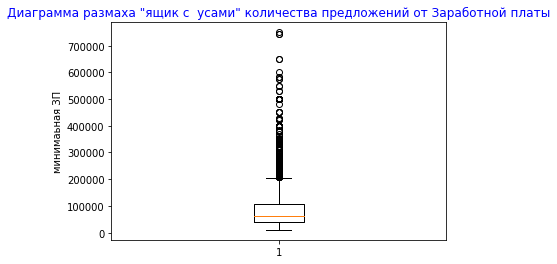

In [ ]:
# Диаграмма размаха - «ящик с усами» — boxplot
plt.boxplot(salary)
plt.title('Диаграмма размаха "ящик с  усами" количества предложений от Заработной платы', color = 'b')
plt.ylabel('минимаьная ЗП')
plt.show()

Видим, что основные данные минимальной зарплаты (прямоугольник) лежат в диапазоне от 50 до 100 тысяч рублей. Медианная ЗП (оранжевая полоса)- около 60000руб. Границы наиболее характерных данных (верхняя и ниняя черта) - в диапазоне от 10 до 200 тысяч руб.

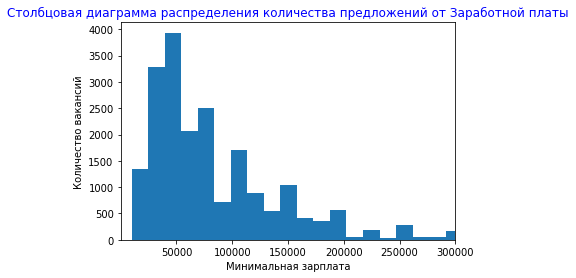

In [ ]:
# Гистограмма
plt.hist(salary, bins = 50)
plt.xlim((1,300000))
plt.title('Столбцовая диаграмма распределения количества предложений от Заработной платы', color = 'b')
plt.ylabel('Количество вакансий')
plt.xlabel('Минимальная зарплата')
plt.show()

Данная диаграмма более наглядна. Видим, что более половины предлоений - с начальной зарплатой от 25 до 80 тысяч рублей

# **Проанализируем категориальные данные:**

**Неграфический анализ:**

In [ ]:
filtered_data['city'].describe()

count      49039
unique       943
top       Москва
freq       14593
Name: city, dtype: object

Из 49039 вакансий - 30% размещено в г.Москва (14593 вакансия)

In [ ]:
# Первая десятка городов по количеству вакансий:
cities = filtered_data['city'].value_counts()
cities[:10]

Москва             14593
Санкт-Петербург     6017
Новосибирск         1952
Екатеринбург        1826
Казань              1477
Нижний Новгород     1360
Краснодар           1062
Ростов-на-Дону       965
Самара               937
Воронеж              832
Name: city, dtype: int64

Первая пятёрка городов по количеству вакансий, в порядке убывания: Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Казань

**Сформируем Датафрейм "Специализация / Заработная плата"**

In [ ]:
df_specializations_salary = filtered_data[['specializations_list','salary_from']]
df_spec_salary = df_specializations_salary.explode('specializations_list')
# Ещё раз фильтруем датасет по интересуемым направленям IT, чтобы убрать мусор
specializ_filter=["игровое по",'web инженер','web мастер',"тестирование",'информационные технологии','интернет',"мультимедиа","телеком","программирование",
                  "аналитик данных","разработка","инженер","сетевые технологии","системный администратор","управление проектами","компьютерная безопасность",
                  "helpdesk","пк","it","1 c","1с","1 с","1c"
                  ]
spec_salary=df_spec_salary.loc[df_spec_salary['specializations_list'].isin(specializ_filter)]
spec_salary.tail()

,specializations_list,salary_from
76345,программирование,35000
76345,разработка,35000
76346,игровое по,<NA>
76346,программирование,<NA>
76346,разработка,<NA>


In [ ]:
spec_salary['specializations_list'].describe()

count      200430
unique         15
top       инженер
freq        35351
Name: specializations_list, dtype: object

In [ ]:
spec_salary['specializations_list'].value_counts()[:20]

инженер                      35351
программирование             27301
разработка                   27301
helpdesk                     16353
системный администратор      16295
web инженер                  15519
web мастер                   15470
интернет                     14052
сетевые технологии           10686
управление проектами          8085
тестирование                  3702
компьютерная безопасность     3223
игровое по                    3211
информационные технологии     2927
мультимедиа                    954
Name: specializations_list, dtype: int64

Самая популярная специальность - Инженер (18% от общего количества). Наиболее часто повторяющиеся специализации в порядке убывания: инженер, программирование, разработка, helpdesk, системный администратор.

**Сформируем Датафрейм "Навыки / Заработная плата"**

In [ ]:
df_sk_salary = filtered_data[['key_skills_list','salary_from']]
df_sk_sal = df_sk_salary.explode('key_skills_list')
# Избавляемся от NaN:
df_not_nan=pd.notnull(df_sk_sal['key_skills_list'])
df_skill_salary=df_sk_sal[df_not_nan]
df_skill_salary.tail

<bound method NDFrame.tail of                    key_skills_list  salary_from
1                              sql         <NA>
1                            linux         <NA>
1      информационная безопасность         <NA>
1           работа с базами данных         <NA>
1                      базы данных         <NA>
...                            ...          ...
76346                   фотомонтаж         <NA>
76346           графический дизайн         <NA>
76346        графические редакторы         <NA>
76346            дизайн полиграфии         <NA>
76346                 креативность         <NA>

[257267 rows x 2 columns]>

In [ ]:

# Фильтруем датасет по интересуемым навыкам, чтобы убрать мусор
skill_filter=['развитие продаж','деловое общение','обучение и развитие','пользователь пк','работа в команде','грамотная речь','высшее образование','работа с пк',
              'работа в условиях многозадачности','управление отделом','организаторские навыки','навыки продаж','оформление документации',
              'материальная ответственность','деловая коммуникация','телефонные переговоры','корпоративная этика','креативность','дизайнер','рисование',
              'творческое мышление','творческие навыки','умение работать в коллективе','умение рисовать','творчество','ответственность и пунктуальность'
              ]
skill_salary=df_skill_salary.loc[~df_skill_salary['key_skills_list'].isin(skill_filter)]
skill_salary.head()

,key_skills_list,salary_from
1,sql,<NA>
1,linux,<NA>
1,информационная безопасность,<NA>
1,работа с базами данных,<NA>
1,базы данных,<NA>


In [ ]:
skill_salary['key_skills_list'].describe()

count     242348
unique     11339
top          sql
freq        5674
Name: key_skills_list, dtype: object

In [ ]:
skill_salary['key_skills_list'].value_counts()[:20]

sql                     5674
linux                   5240
git                     5061
английский язык         3665
управление проектами    3237
javascript              3183
python                  3130
postgresql              2676
1с программирование     2665
java                    2609
1с: предприятие 8       2189
html                    2053
adobe photoshop         1999
ооп                     1993
mysql                   1923
php                     1781
docker                  1754
ms sql                  1729
c#                      1713
css                     1693
Name: key_skills_list, dtype: int64

**ВЫВОДЫ:** Самый популярный навык - SQL (2,3% от общего количества скилов). ТОП-10 навыков (в порядке убывания): SQL, Linux, Git, JavaScript, Python, PostgreSQL, 1C-программирование, Java, HTML, Adobe Photoshop

**Графический анализ:**

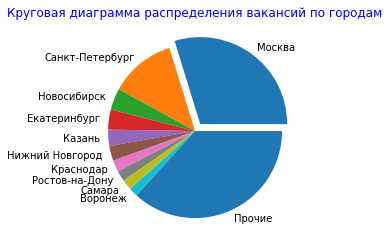

In [ ]:
other = cities[cities<800]
cities_edited = cities[cities>=800]
cities_edited['Прочие'] = other.sum()
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(cities_edited.values, explode=explode, labels = cities_edited.index)
plt.title('Круговая диаграмма распределения вакансий по городам', color = 'b')
plt.show()

Но так как количество категорий у нас больше 5, предпочтительней использовать столбчатую диаграмму:

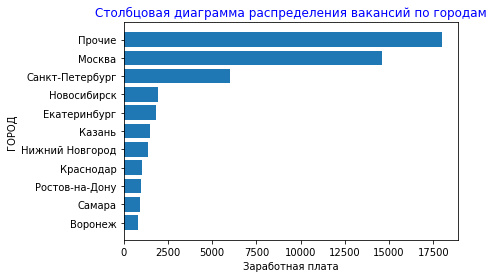

In [ ]:
c=cities_edited.sort_values()
plt.barh(c.index, c.values)
plt.title('Столбцовая диаграмма распределения вакансий по городам', color = 'b')
plt.ylabel('ГОРОД')
plt.xlabel('Заработная плата')
plt.show()

И по круговой и по столбцовой диаграмме однозначно видим - Москва и Санкт-Петербург лидируют по количеству вакансий. Доля других городов после Воронежа - по отдельности невелика, поэтому все они помещены в раздел "Прочие"

# **Проанализируем взаимосвязь колонок**

1) Взаимосвязь Города с Заработной платой.

In [ ]:
# Группируем датасет по городам, берём медиану для каждой группы. Получим медианную ЗП для каждого города.
df_clean_groupby = df_clean.groupby('city')['salary_from'].median().sort_values(ascending=False)
df_clean_groupby[:50]

city
Лучегорск                                 200000.0
Иннополис                                 175550.0
Артемовский (Свердловская область)        150000.0
Гатчина                                   150000.0
Богданович                                150000.0
Волоколамск                               150000.0
Амурск                                    150000.0
Старая Купавна                            140000.0
Тутаев                                    130000.0
Узловая                                   130000.0
Смоленщина                                120000.0
Черноголовка                              115000.0
Ивантеевка                                110000.0
Слюдянка                                  110000.0
Благовещенск (Республика Башкортостан)    109350.0
Монино                                    107500.0
Арамиль                                   105000.0
Егорьевск                                 105000.0
Сысерть                                   105000.0
Ноябрьск                  

In [ ]:
# Здесь можно посмотреть медианную ЗП для любого города России
df_clean_groupby["Челябинск"]

55000.0

In [ ]:
# Считаем другие характеристики
df_clean.groupby('city')['salary_from'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Абакан,19.0,40552.631579,32843.439535,13000.0,19500.0,30000.0,50000.0,150000.0
Абдулино,2.0,49000.0,0.0,49000.0,49000.0,49000.0,49000.0,49000.0
Абинск,2.0,38750.0,20859.650045,24000.0,31375.0,38750.0,46125.0,53500.0
Агеево (Тульская область),1,40000.0,<NA>,40000,40000,40000,40000,40000
Агрыз,1,34000.0,<NA>,34000,34000,34000,34000,34000
...,...,...,...,...,...,...,...,...
Якутск,26.0,50057.653846,36240.993241,13000.0,23000.0,39950.0,67500.0,150000.0
Ялта,8.0,48750.0,26911.229732,25000.0,28750.0,45000.0,53500.0,106000.0
Янаул,1,48700.0,<NA>,48700,48700,48700,48700,48700


Построим Боксплоты для выборочных городов:

<function matplotlib.pyplot.show(*args, **kw)>

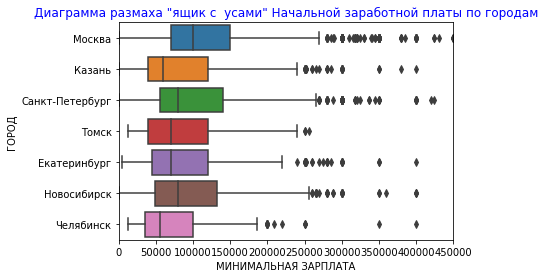

In [ ]:
boxplot_cities=["Москва", "Санкт-Петербург", "Казань", "Челябинск", "Екатеринбург", "Новосибирск", "Томск"]
df_boxplot=filtered_data.loc[filtered_data['city'].isin(boxplot_cities)]
sns.boxplot(x='salary_from', y='city',data=df_boxplot)
plt.title('Диаграмма размаха "ящик с  усами" Начальной заработной платы по городам', color = 'b')
plt.ylabel('ГОРОД')
plt.xlabel('МИНИМАЛЬНАЯ ЗАРПЛАТА')
plt.axis(xmin=0, xmax=450000)
plt.show

Видим, что если в Москве - диапазон Зарплат 70-150тыс.руб., в Челябинске диапазон 35-100тыс.руб. Размах наиболее характерных данных по верхней границе также сильно отличается: в Москве - до 270тыс.руб., а в Челябинске - до 180тыс.руб.

2) Взаимосвязь Навыков с Заработной платой.

In [ ]:
# Группируем датасет по навыкам, берём медиану для каждой группы. Получим медианную ЗП для каждого навыка.
skill_salary.groupby('key_skills_list')['salary_from'].median().sort_values(ascending=False)[:50]

key_skills_list
управление недвижимостью            1000000.0
ibd off cycle intern                 750000.0
revolut                              750000.0
finstar                              750000.0
coinbase                             750000.0
spac                                 750000.0
baring                               750000.0
ipo                                  750000.0
pitch deck                           750000.0
offering memorandum                  750000.0
управление цепочкой поставок         650000.0
recruitment                          636000.0
talent management                    583000.0
people management                    530000.0
продюсирование                       500000.0
ретеншн                              500000.0
монетизация                          500000.0
создание нового продукта             450000.0
data science                         441500.0
фронтэнд                             424000.0
cfa                                  405000.0
strategic planning

Самые высокооплачиваемые скилы - в сфере инвестиций, эл.торговых площадок,системных дененых переводов, биткоинов. Далее, с ЗП от 350 до 450 тыс.руб. - на первом месте можно выделить Data Science, Frontend, Микросервисная архитектура, Java Developer, Webflux,Project Reactor, GCP, Apache Hadoop, Kuberneetes, Fastlane, Многопоточное программирование

In [ ]:
skill_salary.groupby('key_skills_list')['salary_from'].describe()

,count,mean,std,min,25%,50%,75%,max
key_skills_list,,,,,,,,
разработка и поддержка систем обмена данными с сайтом и сторонними сервисами,1,150000.0,<NA>,150000,150000,150000,150000,150000
#junior,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
", qrm",1,100000.0,<NA>,100000,100000,100000,100000,100000
", texture",0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
",realm,",0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...
№187 фз,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
№223 фз,1,70000.0,<NA>,70000,70000,70000,70000,70000
№44 фз,1,70000.0,<NA>,70000,70000,70000,70000,70000


Построим Боксплоты для наиболее интересных Ключевых навыков:

<function matplotlib.pyplot.show(*args, **kw)>

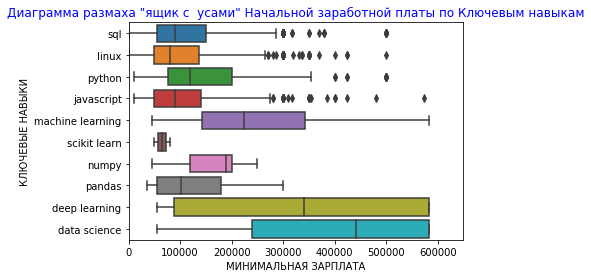

In [ ]:
boxplot_skills=["data science","javascript","deep learning","sql","linux","python","machine learning","pandas","numpy","scikit learn"]
boxpl_skills=skill_salary.loc[skill_salary['key_skills_list'].isin(boxplot_skills)]
sns.boxplot(x='salary_from', y='key_skills_list',data=boxpl_skills)
plt.title('Диаграмма размаха "ящик с  усами" Начальной заработной платы по Ключевым навыкам', color = 'b')
plt.ylabel('КЛЮЧЕВЫЕ НАВЫКИ')
plt.xlabel('МИНИМАЛЬНАЯ ЗАРПЛАТА')
plt.axis(xmin=0, xmax=650000)
plt.show

**Наиболее высокооплачиваемые "скилы:** Deep Learning, Data Sciennce, Machine Learning

3) Взаимосвязь Специализации с Заработной платой.

In [ ]:
# Группируем датасет по специальностям, берём медиану для каждой группы. Получим медианную ЗП для каждой специальности.
spec_salary.groupby('specializations_list')['salary_from'].median().sort_values(ascending=False)

specializations_list
информационные технологии    120000.0
web инженер                  100000.0
web мастер                   100000.0
мультимедиа                  100000.0
тестирование                  91500.0
программирование              80000.0
разработка                    80000.0
управление проектами          80000.0
инженер                       60000.0
компьютерная безопасность     60000.0
сетевые технологии            55000.0
игровое по                    50000.0
helpdesk                      45000.0
системный администратор       45000.0
интернет                      44653.0
Name: salary_from, dtype: Float64

Самые высокооплачиваемые специализации - в сфере информационных технологий (120 000руб.) За ними идут WEB-инженер и WEB-мастер, мультимедиа (100 000руб.). Далее по убыванию: тестирование, программирование, разработка, управление проектами, инженер.

In [ ]:
spec_salary.groupby('specializations_list')['salary_from'].describe()

,count,mean,std,min,25%,50%,75%,max
specializations_list,,,,,,,,
helpdesk,7843.0,54611.330996,41904.864760,42.0,30000.0,45000.0,65000.0,424000.0
web инженер,7004.0,111543.463735,71341.759838,1.0,60000.0,100000.0,150000.0,600000.0
web мастер,6995.0,111546.679056,71372.453550,1.0,60000.0,100000.0,150000.0,600000.0
игровое по,1432.0,62999.820531,40275.549963,35.0,35000.0,50000.0,80000.0,300000.0
инженер,15426.0,83273.940879,64520.360227,1.0,40000.0,60000.0,106000.0,600000.0
интернет,6925.0,56052.887798,47518.028264,42.0,30000.0,44653.0,65000.0,750000.0
информационные технологии,743.0,141036.458950,101391.696018,70.0,75000.0,120000.0,170000.0,750000.0
компьютерная безопасность,1107.0,68682.677507,43049.859969,9000.0,40000.0,60000.0,90000.0,300000.0
мультимедиа,295.0,122574.677966,99272.555479,15000.0,70000.0,100000.0,150000.0,750000.0


Построим Боксплоты для наиболее интересных Cпециализаций:

In [ ]:
spec_salary

,specializations_list,salary_from
0,тестирование,<NA>
0,информационные технологии,<NA>
0,интернет,<NA>
0,мультимедиа,<NA>
1,программирование,<NA>
...,...,...
76345,программирование,35000
76345,разработка,35000
76346,игровое по,<NA>
76346,программирование,<NA>


<function matplotlib.pyplot.show(*args, **kw)>

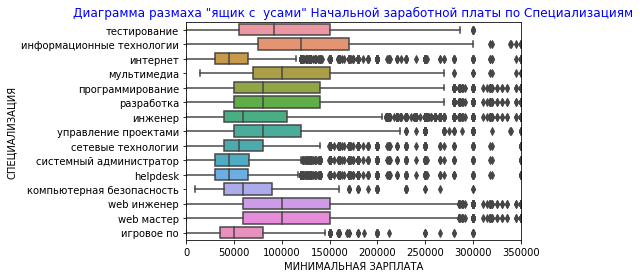

In [ ]:
sns.boxplot(x='salary_from', y='specializations_list',data=spec_salary)
plt.title('Диаграмма размаха "ящик с  усами" Начальной заработной платы по Специализациям', color = 'b')
plt.ylabel('СПЕЦИАЛИЗАЦИЯ')
plt.xlabel('МИНИМАЛЬНАЯ ЗАРПЛАТА')
plt.axis(xmin=0, xmax=350000)
plt.show

Наиболее высокие зарплаты - в Информационных технологиях. Далее идёт Тестирование. Далее - пракдически одинаковый диапазон зарплат у Программирования, Разработка, Мультимедиа, Web-инженер, Web-мастер.

4) Взаимосвязь Ключевых навыков по городам.

In [ ]:
# Используем уже отфильтрованный по выборочным выше городам Датасет: df_boxplot
df_sk_city = df_boxplot[['key_skills_list','city']]
df_sk_cit = df_sk_city.explode('key_skills_list')
# Избавляемся от NaN:
sk_cit_not_nan=pd.notnull(df_sk_cit['key_skills_list'])
df_skill_city=df_sk_cit[sk_cit_not_nan]
df_skill_city

,key_skills_list,city
11190,sql,Москва
11190,xml,Москва
11190,функциональное тестирование,Москва
11190,тестирование,Москва
11190,soap,Москва
...,...,...
74389,adobe photoshop,Челябинск
74389,coreldraw,Челябинск
74389,веб дизайн,Челябинск
74389,графические редакторы,Челябинск


In [ ]:
# Фильтруем датасет по интересуемым навыкам, которые выбирали выше при построении диаграммы размаха "ЗП/Ключевые навыки"
skill_clean_city=df_skill_city.loc[df_skill_city['key_skills_list'].isin(boxplot_skills)]

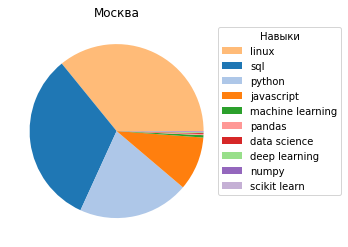

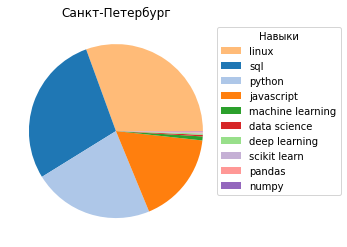

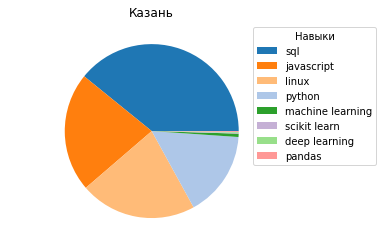

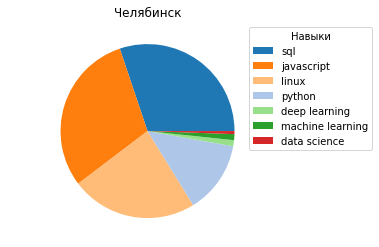

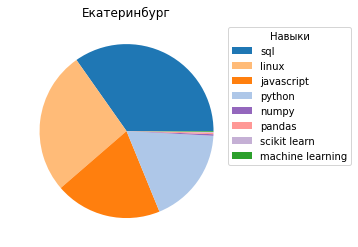

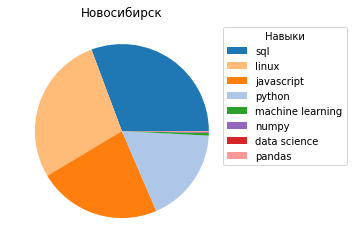

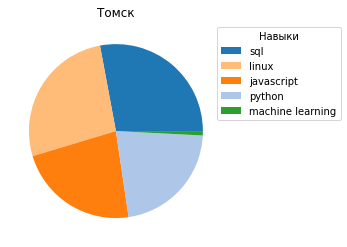

In [ ]:
# ПРИМ.: переменная с городами = boxplot_cities
labels=skill_clean_city['key_skills_list'].unique()
colors=dict(zip(labels,plt.cm.tab20.colors[:len(labels)]))
for city in boxplot_cities:
  dataset=skill_clean_city[skill_clean_city['city']==city]
  class_counts=dataset['key_skills_list'].value_counts()
  labels=class_counts.index
  plt.title(city)
  patches,texts = plt.pie(class_counts.values,labels = labels,colors = [colors[key] for key in labels],textprops=dict(color="w"))
  plt.legend(patches,labels,title="Навыки", loc="upper center", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.show()

Видим, что в разных городах - распределение интересуемых работодателей ключевых навыков довольно сильно различаются между собой

5) Взаимосвязь Специализаций по городам.

In [ ]:
# Используем уже отфильтрованный по выборочным выше городам Датасет (df_boxplot) и готовый выше фильтр специализаций (specializ_filter)
df_specializations_city = df_boxplot[['specializations_list','city']]
df_spec_city = df_specializations_city.explode('specializations_list')
# Ещё раз фильтруем датасет по интересуемым направленям IT, чтобы убрать мусор
spec_city=df_spec_city.loc[df_spec_city['specializations_list'].isin(specializ_filter)]
spec_city

,specializations_list,city
11189,программирование,Москва
11189,разработка,Москва
11189,инженер,Москва
11189,тестирование,Москва
11190,программирование,Москва
...,...,...
74388,программирование,Челябинск
74388,разработка,Челябинск
74389,игровое по,Челябинск
74389,программирование,Челябинск


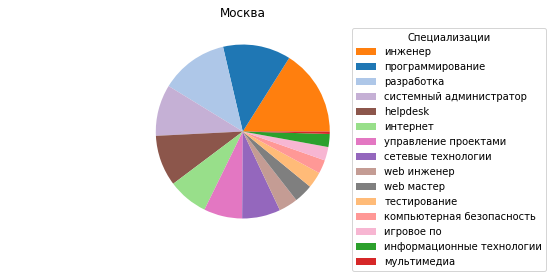

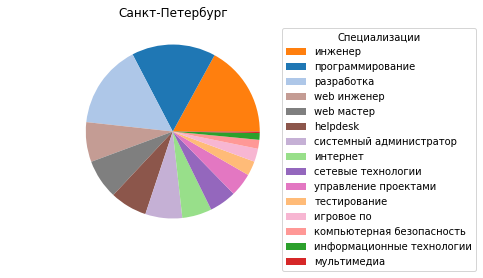

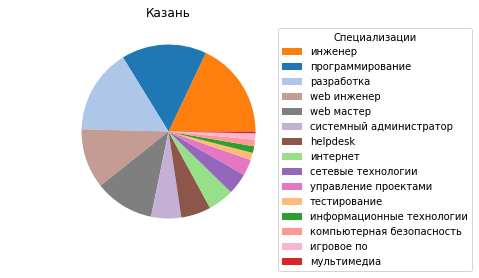

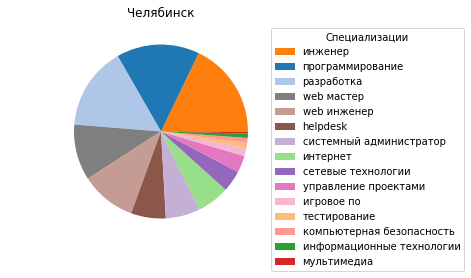

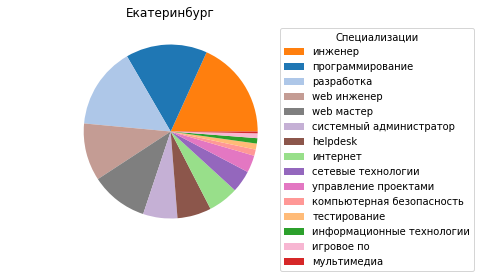

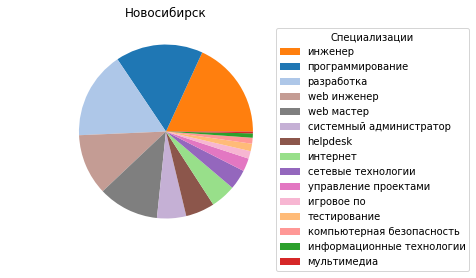

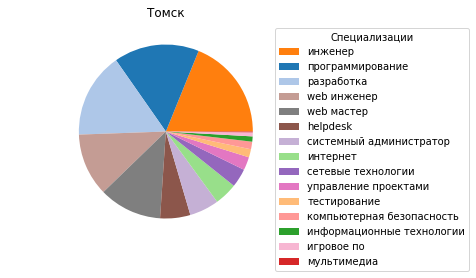

In [ ]:
# ПРИМ.: переменная с городами = boxplot_cities
labels_=spec_city['specializations_list'].unique()
colors_=dict(zip(labels_,plt.cm.tab20.colors[:len(labels_)]))
for city in boxplot_cities:
  dataset=spec_city[spec_city['city']==city]
  class_counts=dataset['specializations_list'].value_counts()
  labels_=class_counts.index
  plt.title(city)
  patches_,texts_ = plt.pie(class_counts.values,labels = labels_,colors = [colors_[key] for key in labels_],textprops=dict(color="w"))
  plt.legend(patches_,labels_,title="Специализации", loc="upper center", bbox_to_anchor=(1.2, 0, 0.5, 1))
  plt.show()

Во всех городах - самые востребованные специализации: инженер, программирование, разработка.

# **ИТОГИ**

**Числовые данные Заработной платы:**
20401 вакансия, средняя ЗП: 84 400 руб; медианная ЗП: 63 000 руб; максимальная ЗП: 750 000 руб.
Видим, что основные данные минимальной зарплаты (прямоугольник) лежат в диапазоне от 50 до 100 тысяч рублей. Медианная ЗП (оранжевая полоса)- около 60000руб. Границы наиболее характерных данных (верхняя и ниняя черта) - в диапазоне от 10 до 200 тысяч руб.
Данная диаграмма более наглядна. Видим, что более половины предлоений - с начальной зарплатой от 25 до 80 тысяч рублей

**Категориальные данные. Города.**
Из 49039 вакансий - 30% размещено в г.Москва (14593 вакансия)
Первая пятёрка городов по количеству вакансий, в порядке убывания: Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Казань

Самая популярная специальность - Инженер (18% от общего количества). Наиболее часто повторяющиеся специализации в порядке убывания: инженер, программирование, разработка, helpdesk, системный администратор.

Самый популярный навык - SQL (2,3% от общего количества скилов). ТОП-10 навыков (в порядке убывания): SQL, Linux, Git, JavaScript, Python, PostgreSQL, 1C-программирование, Java, HTML, Adobe Photoshop

И по круговой и по столбцовой диаграмме однозначно видим - Москва и Санкт-Петербург лидируют по количеству вакансий. Доля других городов после Воронежа - по отдельности невелика, поэтому все они помещены в раздел "Прочие"

**Взаимосвязь колонок**
Видим, что если в Москве - диапазон Зарплат 70-150тыс.руб., в Челябинске диапазон 35-100тыс.руб. Размах наиболее характерных данных по верхней границе также сильно отличается: в Москве - до 270тыс.руб., а в Челябинске - до 180тыс.руб.

Самые высокооплачиваемые скилы - в сфере инвестиций, эл.торговых площадок,системных дененых переводов, биткоинов. Далее, с ЗП от 350 до 450 тыс.руб. - на первом месте можно выделить Data Science, Frontend, Микросервисная архитектура, Java Developer, Webflux,Project Reactor, GCP, Apache Hadoop, Kuberneetes, Fastlane, Многопоточное программирование

Наиболее высокооплачиваемые "скилы: Deep Learning, Data Sciennce, Machine Learning

Самые высокооплачиваемые специализации - в сфере информационных технологий (120 000руб.) За ними идут WEB-инженер и WEB-мастер, мультимедиа (100 000руб.). Далее по убыванию: тестирование, программирование, разработка, управление проектами, инженер.

Наиболее высокие зарплаты - в Информационных технологиях. Далее идёт Тестирование. Далее - пракдически одинаковый диапазон зарплат у Программирования, Разработка, Мультимедиа, Web-инженер, Web-мастер.

Видим, что в разных городах - распределение интересуемых работодателей ключевых навыков довольно сильно различаются между собой

Во всех городах - самые востребованные специализации: инженер, программирование, разработка.

In [ ]:
# Сохраним готовые датасеты в файлы Exel
filtered_data.to_excel('filtered_data.xlsx')
spec_salary.to_excel('spec_salary.xlsx')
skill_salary.to_excel('skill_salary.xlsx')